In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers



In [8]:

df = pd.read_csv("spam.csv",encoding='latin-1')
df.head()



v1                                                 v2 Unnamed: 2  \
0   ham  Go until jurong point, crazy.. Available only ...        NaN   
1   ham                      Ok lar... Joking wif u oni...        NaN   
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...        NaN   
3   ham  U dun say so early hor... U c already then say...        NaN   
4   ham  Nah I don't think he goes to usf, he lives aro...        NaN   

  Unnamed: 3 Unnamed: 4  
0        NaN        NaN  
1        NaN        NaN  
2        NaN        NaN  
3        NaN        NaN  
4        NaN        NaN

In [9]:
df=df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df=df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0,'spam':1})
df.head()



label                                               Text  label_enc
0   ham  Go until jurong point, crazy.. Available only ...          0
1   ham                      Ok lar... Joking wif u oni...          0
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...          1
3   ham  U dun say so early hor... U c already then say...          0
4   ham  Nah I don't think he goes to usf, he lives aro...          0

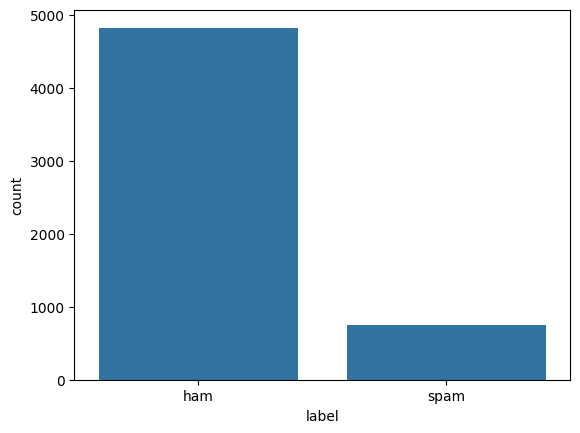

In [10]:
sns.countplot(x=df['label'])
plt.show()


In [11]:

avg_words_len=round(sum([len(i.split()) for i in df['Text']])/len(df['Text']))
print(avg_words_len)



15


In [12]:
# Finding Total no of unique words in corpus
s = set()
for sent in df['Text']:
    for word in sent.split():
	    s.add(word)
total_words_length=len(s)
print(total_words_length)


15585


In [13]:
# Splitting data for Training and testing
from sklearn.model_selection import train_test_split

X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(
	new_df['Text'], new_df['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((4457,), (4457,), (1115,), (1115,))

In [14]:
pip install scikit-learn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score

tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)

baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec,y_train)
nb_accuracy=accuracy_score(y_test,baseline_model.predict(X_test_vec))
print(nb_accuracy)
print(classification_report(y_test,baseline_model.predict(X_test_vec)))


0.9623318385650225
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       965
           1       1.00      0.72      0.84       150

    accuracy                           0.96      1115
   macro avg       0.98      0.86      0.91      1115
weighted avg       0.96      0.96      0.96      1115



In [16]:
pip install plot_confusion matrix


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement plot_confusion (from versions: none)
ERROR: No matching distribution found for plot_confusion

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


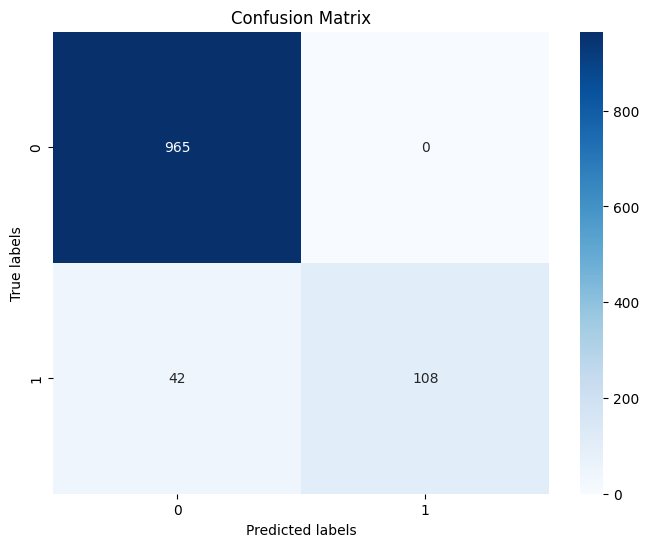

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming y_true and y_pred are your true and predicted labels
# Compute confusion matrix
cm = confusion_matrix(y_test, baseline_model.predict(X_test_vec))

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()




In [18]:
from tensorflow.keras.layers import TextVectorization

MAXTOKENS=total_words_length
OUTPUTLEN=avg_words_len

text_vec = TextVectorization(
	max_tokens=MAXTOKENS,
	standardize='lower_and_strip_punctuation',
	output_mode='int',
	output_sequence_length=OUTPUTLEN
)
text_vec.adapt(X_train)
sample_sentence="this is a message"
text_vec([sample_sentence])


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[ 41,  10,   5, 148,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0]], dtype=int64)>

In [19]:
embedding_layer = layers.Embedding(
	input_dim=MAXTOKENS,
	output_dim=128,
	embeddings_initializer='uniform',
	input_length=OUTPUTLEN
)


In [20]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)

model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(
	label_smoothing=0.5), metrics=['accuracy'])
model_1.summary()



Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 15)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 15, 128)           1994880   
                                                                 
 global_average_pooling1d (  (None, 128)               0         
 GlobalAveragePooling1D)                                         
                                                                 
 flatten (Flatten)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 32)                4128 

In [21]:
history_1=model_1.fit(X_train,y_train,epochs=5,validation_data=(X_test,y_test),validation_steps=int(0.2*len(X_test)))

Epoch 1/5

140/140 [==============================] - 4s 23ms/step - loss: 0.6051 - accuracy: 0.9132 - val_loss: 0.5775 - val_accuracy: 0.9740
Epoch 2/5
140/140 [==============================] - 3s 23ms/step - loss: 0.5701 - accuracy: 0.9872 - val_loss: 0.5736 - val_accuracy: 0.9830
Epoch 3/5
140/140 [==============================] - 3s 22ms/step - loss: 0.5658 - accuracy: 0.9962 - val_loss: 0.5726 - val_accuracy: 0.9821
Epoch 4/5
140/140 [==============================] - 3s 20ms/step - loss: 0.5642 - accuracy: 0.9984 - val_loss: 0.5728 - val_accuracy: 0.9812
Epoch 5/5
140/140 [==============================] - 3s 22ms/step - loss: 0.5634 - accuracy: 0.9991 - val_loss: 0.5727 - val_accuracy: 0.9785


<Axes: >

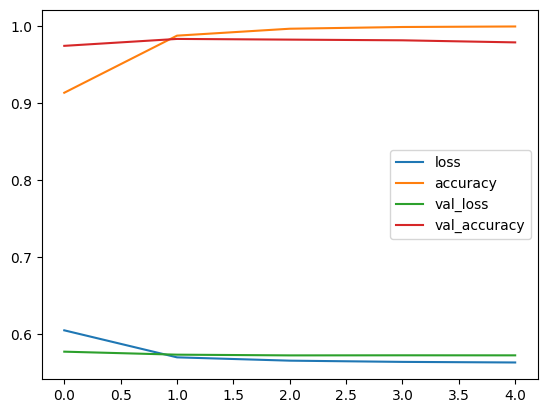

In [22]:
pd.DataFrame(history_1.history).plot()

In [23]:
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_model(model, X, y):
	'''
	evaluate the model and returns accuracy, 
	precision, recall and f1-score 
	'''
	y_preds = np.round(model.predict(X))
	accuracy = accuracy_score(y, y_preds)
	precision = precision_score(y, y_preds)
	recall = recall_score(y, y_preds)
	f1 = f1_score(y, y_preds)

	model_results_dict = {'accuracy': accuracy,
						'precision': precision,
						'recall': recall,
						'f1-score': f1}

	return model_results_dict


In [24]:
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
model_1_results = evaluate_model(model_1, X_test, y_test)


total_results = pd.DataFrame({'MultinomialNB Model':baseline_model_results,
							'Custom-Vec-Embedding Model':model_1_results}).transpose()

total_results


35/35 [==============================] - 0s 3ms/step


accuracy  precision    recall  f1-score
MultinomialNB Model         0.962332   1.000000  0.720000  0.837209
Custom-Vec-Embedding Model  0.978475   0.963235  0.873333  0.916084

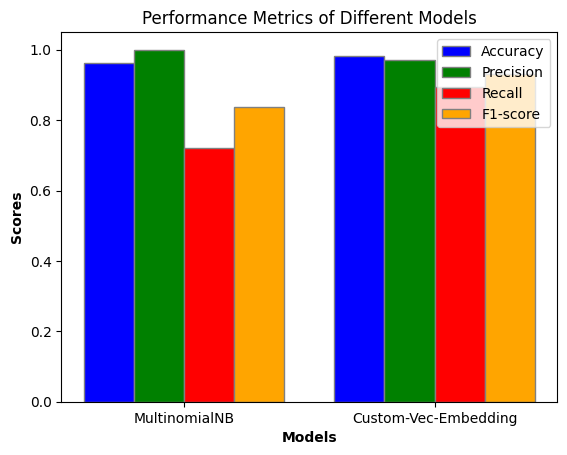

In [25]:
import matplotlib.pyplot as plt


models = ['MultinomialNB', 'Custom-Vec-Embedding']

accuracy = [0.962332, 0.982063]
precision = [1.000000, 0.971014]
recall = [0.720000, 0.893333]
f1_score = [0.837209, 0.930556]


bar_width = 0.2


r1 = range(len(models))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]


plt.bar(r1, accuracy, color='b', width=bar_width, edgecolor='grey', label='Accuracy')
plt.bar(r2, precision, color='g', width=bar_width, edgecolor='grey', label='Precision')
plt.bar(r3, recall, color='r', width=bar_width, edgecolor='grey', label='Recall')
plt.bar(r4, f1_score, color='orange', width=bar_width, edgecolor='grey', label='F1-score')


plt.xlabel('Models', fontweight='bold')
plt.xticks([r + bar_width*1.5 for r in range(len(models))], models)
plt.ylabel('Scores', fontweight='bold')
plt.title('Performance Metrics of Different Models')
plt.legend()


plt.show()
